## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 65.2MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [ ]:
!pip install category_encoders
!pip install optuna
!pip install pandas
!pip install japanize-matplotlib

     |████████████████████████████████| 82 kB 392 kB/s 
     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 33.5 MB/s 
     |████████████████████████████████| 80 kB 7.5 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 149 kB 50.7 MB/s 
     |████████████████████████████████| 112 kB 52.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=f1b26b1bbcca9f405425d0f2064a373b358af98c3dfae2758e33b6677dbc2638
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 4.1 MB 5.2 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=21dd9180e428f68024a22086a5d17256afcea3b27d420ec6eee43a2114298d2f
  Stored in direct

In [ ]:
import os
import time
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 

import optuna.integration.lightgbm as lgb
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [ ]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

## モデルの保存

[I 2021-12-15 12:10:02,830] A new study created in memory with name: no-name-32acc05c-0b88-40e7-8b1b-1a175040e135


Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:03,313] Trial 0 finished with value: 0.34564286351667656 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.34564286351667656.


Early stopping, best iteration is:
[47]	Train's rmse: 0.142844	Test's rmse: 0.345643
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:03,779] Trial 1 finished with value: 0.34507429978353893 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.34507429978353893.


Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:04,131] Trial 2 finished with value: 0.3573903807852102 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.34507429978353893.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121108	Test's rmse: 0.35739
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:04,594] Trial 3 finished with value: 0.35225673206710856 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.34507429978353893.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.104324	Test's rmse: 0.352257
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:05,086] Trial 4 finished with value: 0.3407631315214147 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 0.3407631315214147.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108445	Test's rmse: 0.340763
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:05,517] Trial 5 finished with value: 0.3641209844575373 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 0.3407631315214147.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108089	Test's rmse: 0.364121
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:05,913] Trial 6 finished with value: 0.35741087866232285 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 0.3407631315214147.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.116552	Test's rmse: 0.357411
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:06,600] Trial 7 finished with value: 0.3455402141716164 and parameters: {'num_leaves': 61}. Best is trial 7 with value: 0.3455402141716164.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111854	Test's rmse: 0.34554
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:06,960] Trial 8 finished with value: 0.3447002352162008 and parameters: {'num_leaves': 23}. Best is trial 8 with value: 0.3447002352162008.


Early stopping, best iteration is:
[42]	Train's rmse: 0.147516	Test's rmse: 0.3447
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:08,748] Trial 9 finished with value: 0.3494865705299206 and parameters: {'num_leaves': 234}. Best is trial 8 with value: 0.3447002352162008.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108062	Test's rmse: 0.349487
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:10,527] Trial 10 finished with value: 0.3491125718635729 and parameters: {'num_leaves': 246}. Best is trial 8 with value: 0.3447002352162008.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112908	Test's rmse: 0.349113
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:11,207] Trial 11 finished with value: 0.3447699693144058 and parameters: {'num_leaves': 60}. Best is trial 8 with value: 0.3447002352162008.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1133	Test's rmse: 0.34477
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:11,871] Trial 12 finished with value: 0.3432868043682804 and parameters: {'num_leaves': 56}. Best is trial 12 with value: 0.3432868043682804.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.107605	Test's rmse: 0.343287
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:12,336] Trial 13 finished with value: 0.3384541017873612 and parameters: {'num_leaves': 34}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.108582	Test's rmse: 0.338454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:13,056] Trial 14 finished with value: 0.3406980972573652 and parameters: {'num_leaves': 63}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110712	Test's rmse: 0.340698
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:14,860] Trial 15 finished with value: 0.34721397182891556 and parameters: {'num_leaves': 243}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.11263	Test's rmse: 0.347214
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:16,016] Trial 16 finished with value: 0.34957920929866204 and parameters: {'num_leaves': 131}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109741	Test's rmse: 0.349579
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:17,263] Trial 17 finished with value: 0.3451459697252792 and parameters: {'num_leaves': 146}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111373	Test's rmse: 0.345146
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:17,485] Trial 18 finished with value: 0.3477900575394168 and parameters: {'num_leaves': 7}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12141	Test's rmse: 0.34779
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:18,403] Trial 19 finished with value: 0.34414085377570125 and parameters: {'num_leaves': 97}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.110296	Test's rmse: 0.344141
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:19,333] Trial 20 finished with value: 0.34487591966740877 and parameters: {'num_leaves': 96}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109824	Test's rmse: 0.344876
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:20,810] Trial 21 finished with value: 0.34884455565858186 and parameters: {'num_leaves': 184}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112436	Test's rmse: 0.348845
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:21,304] Trial 22 finished with value: 0.3498389794187244 and parameters: {'num_leaves': 36}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111416	Test's rmse: 0.349839
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:22,215] Trial 23 finished with value: 0.3492696144789494 and parameters: {'num_leaves': 93}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.111556	Test's rmse: 0.34927
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:23,617] Trial 24 finished with value: 0.34607954458620704 and parameters: {'num_leaves': 171}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114872	Test's rmse: 0.34608
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:24,472] Trial 25 finished with value: 0.35012004491801574 and parameters: {'num_leaves': 85}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.109056	Test's rmse: 0.35012
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:25,009] Trial 26 finished with value: 0.34441055223242273 and parameters: {'num_leaves': 37}. Best is trial 13 with value: 0.3384541017873612.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.113481	Test's rmse: 0.344411
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:25,572] Trial 27 finished with value: 0.3481785462001098 and parameters: {'bagging_fraction': 0.9540471454090393, 'bagging_freq': 5}. Best is trial 27 with value: 0.3481785462001098.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.114326	Test's rmse: 0.348179
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:26,107] Trial 28 finished with value: 0.33741643468316285 and parameters: {'bagging_fraction': 0.4549144223055764, 'bagging_freq': 5}. Best is trial 28 with value: 0.33741643468316285.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158204	Test's rmse: 0.337416
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:26,629] Trial 29 finished with value: 0.3364410759423888 and parameters: {'bagging_fraction': 0.5442325835822589, 'bagging_freq': 6}. Best is trial 29 with value: 0.3364410759423888.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146249	Test's rmse: 0.336441
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:27,178] Trial 30 finished with value: 0.32382549917785725 and parameters: {'bagging_fraction': 0.5829096402548706, 'bagging_freq': 2}. Best is trial 30 with value: 0.32382549917785725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144946	Test's rmse: 0.323825
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:27,698] Trial 31 finished with value: 0.32640018436708085 and parameters: {'bagging_fraction': 0.5712041997652549, 'bagging_freq': 2}. Best is trial 30 with value: 0.32382549917785725.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144201	Test's rmse: 0.3264
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:28,252] Trial 32 finished with value: 0.32145386441300483 and parameters: {'bagging_fraction': 0.4183736662660874, 'bagging_freq': 1}. Best is trial 32 with value: 0.32145386441300483.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156174	Test's rmse: 0.321454
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:28,779] Trial 33 finished with value: 0.33173875658442054 and parameters: {'bagging_fraction': 0.7285072481982622, 'bagging_freq': 4}. Best is trial 32 with value: 0.32145386441300483.


Early stopping, best iteration is:
[49]	Train's rmse: 0.160635	Test's rmse: 0.331739
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:29,288] Trial 34 finished with value: 0.32096036874095896 and parameters: {'bagging_fraction': 0.8201756317483551, 'bagging_freq': 1}. Best is trial 34 with value: 0.32096036874095896.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133209	Test's rmse: 0.32096
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:29,829] Trial 35 finished with value: 0.3312943251177972 and parameters: {'bagging_fraction': 0.694692418340116, 'bagging_freq': 2}. Best is trial 34 with value: 0.32096036874095896.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138812	Test's rmse: 0.331294
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:30,361] Trial 36 finished with value: 0.3280038247975383 and parameters: {'bagging_fraction': 0.6231968439964253, 'bagging_freq': 3}. Best is trial 34 with value: 0.32096036874095896.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145361	Test's rmse: 0.328004
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:30,853] Trial 37 finished with value: 0.3201556722049721 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.3201556722049721.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132369	Test's rmse: 0.320156
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:31,352] Trial 38 finished with value: 0.32096036874095896 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.3201556722049721.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133209	Test's rmse: 0.32096
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:31,847] Trial 39 finished with value: 0.3201556722049721 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.3201556722049721.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132369	Test's rmse: 0.320156
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:32,342] Trial 40 finished with value: 0.32096036874095896 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 0.3201556722049721.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133209	Test's rmse: 0.32096
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:32,815] Trial 41 finished with value: 0.33951128031632133 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.3201556722049721.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128162	Test's rmse: 0.339511
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:33,331] Trial 42 finished with value: 0.3182710328541911 and parameters: {'feature_fraction': 0.88}. Best is trial 42 with value: 0.3182710328541911.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137668	Test's rmse: 0.318271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:33,812] Trial 43 finished with value: 0.32320659713176875 and parameters: {'lambda_l1': 0.7334198267988105, 'lambda_l2': 0.7338909034416901}. Best is trial 43 with value: 0.32320659713176875.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135106	Test's rmse: 0.323207
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:34,336] Trial 44 finished with value: 0.3190807251965779 and parameters: {'lambda_l1': 7.577062999807938e-05, 'lambda_l2': 0.991676170167927}. Best is trial 44 with value: 0.3190807251965779.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136703	Test's rmse: 0.319081
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:34,852] Trial 45 finished with value: 0.3182710329650337 and parameters: {'lambda_l1': 7.659107260113919e-08, 'lambda_l2': 2.5688501041262217e-07}. Best is trial 45 with value: 0.3182710329650337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137668	Test's rmse: 0.318271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:35,241] Trial 46 finished with value: 0.3312701262177367 and parameters: {'lambda_l1': 7.58067767185021, 'lambda_l2': 2.1937833986342256e-07}. Best is trial 45 with value: 0.3182710329650337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139649	Test's rmse: 0.33127
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:35,779] Trial 47 finished with value: 0.318271106879295 and parameters: {'lambda_l1': 4.2513500740477706e-05, 'lambda_l2': 2.6982136748595097e-05}. Best is trial 45 with value: 0.3182710329650337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137668	Test's rmse: 0.318271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:36,337] Trial 48 finished with value: 0.32027641132513096 and parameters: {'lambda_l1': 0.004521826761287237, 'lambda_l2': 2.1400822674912114}. Best is trial 45 with value: 0.3182710329650337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138176	Test's rmse: 0.320276
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:36,837] Trial 49 finished with value: 0.3213434926786573 and parameters: {'lambda_l1': 0.36398996333539074, 'lambda_l2': 3.2170984549632e-08}. Best is trial 45 with value: 0.3182710329650337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135348	Test's rmse: 0.321343
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:37,383] Trial 50 finished with value: 0.32035527166373584 and parameters: {'lambda_l1': 0.11646944302121318, 'lambda_l2': 6.478508580198945e-05}. Best is trial 45 with value: 0.3182710329650337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133843	Test's rmse: 0.320355
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:37,911] Trial 51 finished with value: 0.3189709412468168 and parameters: {'lambda_l1': 0.0006577038865231322, 'lambda_l2': 0.00015312744384491576}. Best is trial 45 with value: 0.3182710329650337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139039	Test's rmse: 0.318971
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:38,457] Trial 52 finished with value: 0.3189708749752083 and parameters: {'lambda_l1': 0.0006153227892021464, 'lambda_l2': 2.262566634167268e-08}. Best is trial 45 with value: 0.3182710329650337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139039	Test's rmse: 0.318971
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:38,978] Trial 53 finished with value: 0.3201008554331405 and parameters: {'lambda_l1': 1.1658558967815658e-08, 'lambda_l2': 0.010541771535725114}. Best is trial 45 with value: 0.3182710329650337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136224	Test's rmse: 0.320101
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:39,502] Trial 54 finished with value: 0.31827103353506986 and parameters: {'lambda_l1': 4.19700179984955e-07, 'lambda_l2': 2.350296624255239e-06}. Best is trial 45 with value: 0.3182710329650337.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137668	Test's rmse: 0.318271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:40,064] Trial 55 finished with value: 0.31827103295295517 and parameters: {'lambda_l1': 7.347047297383403e-08, 'lambda_l2': 1.3696757998163466e-06}. Best is trial 55 with value: 0.31827103295295517.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137668	Test's rmse: 0.318271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:40,593] Trial 56 finished with value: 0.3182710332719442 and parameters: {'lambda_l1': 3.247154599050401e-07, 'lambda_l2': 1.7211760907518176e-06}. Best is trial 55 with value: 0.31827103295295517.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137668	Test's rmse: 0.318271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:41,106] Trial 57 finished with value: 0.31909522220304654 and parameters: {'lambda_l1': 1.0053405501388568e-08, 'lambda_l2': 0.003315981286936372}. Best is trial 55 with value: 0.31827103295295517.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139029	Test's rmse: 0.319095
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:41,630] Trial 58 finished with value: 0.31827103424657854 and parameters: {'lambda_l1': 8.197340038915225e-07, 'lambda_l2': 2.295559671391911e-06}. Best is trial 55 with value: 0.31827103295295517.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137668	Test's rmse: 0.318271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:42,128] Trial 59 finished with value: 0.31827104383292953 and parameters: {'lambda_l1': 6.251623805080845e-06, 'lambda_l2': 2.4190237129951565e-07}. Best is trial 55 with value: 0.31827103295295517.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137668	Test's rmse: 0.318271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:42,644] Trial 60 finished with value: 0.31849360220790757 and parameters: {'lambda_l1': 5.2033406150860006e-08, 'lambda_l2': 0.0015146003660347063}. Best is trial 55 with value: 0.31827103295295517.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140158	Test's rmse: 0.318494
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:43,166] Trial 61 finished with value: 0.318271037080861 and parameters: {'lambda_l1': 2.647254957571595e-06, 'lambda_l2': 1.3308979608953577e-05}. Best is trial 55 with value: 0.31827103295295517.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137668	Test's rmse: 0.318271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:43,708] Trial 62 finished with value: 0.3182710331210188 and parameters: {'lambda_l1': 1.5848447683976994e-07, 'lambda_l2': 1.7726364950405905e-07}. Best is trial 55 with value: 0.31827103295295517.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137668	Test's rmse: 0.318271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:44,234] Trial 63 finished with value: 0.40253011486547635 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.40253011486547635.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.252123	Test's rmse: 0.40253
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:44,724] Trial 64 finished with value: 0.3469096708194726 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.3469096708194726.


Early stopping, best iteration is:
[44]	Train's rmse: 0.10751	Test's rmse: 0.34691
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:45,995] Trial 65 finished with value: 0.3766801283028537 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.3469096708194726.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.207471	Test's rmse: 0.37668
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:46,490] Trial 66 finished with value: 0.3477502567300572 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 0.3469096708194726.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0253323	Test's rmse: 0.34775
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:47,007] Trial 67 finished with value: 0.31681978895152546 and parameters: {'min_child_samples': 25}. Best is trial 67 with value: 0.31681978895152546.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142274	Test's rmse: 0.31682


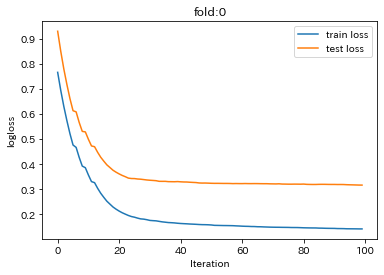

[I 2021-12-15 12:10:47,241] A new study created in memory with name: no-name-9f58cd4c-e689-433d-9df9-a05adfb32c16


Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:47,751] Trial 0 finished with value: 0.11199663372018694 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.11199663372018694.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:48,224] Trial 1 finished with value: 0.11007959705896872 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.11007959705896872.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146464	Test's rmse: 0.11008
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:48,698] Trial 2 finished with value: 0.10719557951928363 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131381	Test's rmse: 0.107196
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:49,082] Trial 3 finished with value: 0.13610145954023592 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133052	Test's rmse: 0.136101
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:49,439] Trial 4 finished with value: 0.13951428268921193 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140926	Test's rmse: 0.139514
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:49,862] Trial 5 finished with value: 0.10971220492343477 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128728	Test's rmse: 0.109712
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:50,301] Trial 6 finished with value: 0.12471472614397411 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.10719557951928363.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131213	Test's rmse: 0.124715
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:52,040] Trial 7 finished with value: 0.1135292053541052 and parameters: {'num_leaves': 233}. Best is trial 7 with value: 0.1135292053541052.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131245	Test's rmse: 0.113529
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:52,348] Trial 8 finished with value: 0.10723023657602192 and parameters: {'num_leaves': 15}. Best is trial 8 with value: 0.10723023657602192.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135815	Test's rmse: 0.10723
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:54,039] Trial 9 finished with value: 0.11645120532964132 and parameters: {'num_leaves': 219}. Best is trial 8 with value: 0.10723023657602192.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130809	Test's rmse: 0.116451
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:55,640] Trial 10 finished with value: 0.11472214660674829 and parameters: {'num_leaves': 203}. Best is trial 8 with value: 0.10723023657602192.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128666	Test's rmse: 0.114722
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:56,960] Trial 11 finished with value: 0.11523802642655778 and parameters: {'num_leaves': 155}. Best is trial 8 with value: 0.10723023657602192.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136845	Test's rmse: 0.115238
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:58,003] Trial 12 finished with value: 0.1126298405180178 and parameters: {'num_leaves': 115}. Best is trial 8 with value: 0.10723023657602192.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132426	Test's rmse: 0.11263
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:59,205] Trial 13 finished with value: 0.11346526561050937 and parameters: {'num_leaves': 136}. Best is trial 8 with value: 0.10723023657602192.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133541	Test's rmse: 0.113465
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:10:59,904] Trial 14 finished with value: 0.10963187051404438 and parameters: {'num_leaves': 63}. Best is trial 8 with value: 0.10723023657602192.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131644	Test's rmse: 0.109632
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:01,717] Trial 15 finished with value: 0.1174744784365156 and parameters: {'num_leaves': 253}. Best is trial 8 with value: 0.10723023657602192.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136922	Test's rmse: 0.117474
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:02,420] Trial 16 finished with value: 0.10784182596665629 and parameters: {'num_leaves': 65}. Best is trial 8 with value: 0.10723023657602192.
[I 2021-12-15 12:11:02,556] Trial 17 finished with value: 0.12256563719876422 and parameters: {'num_leaves': 2}. Best is trial 8 with value: 0.10723023657602192.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135998	Test's rmse: 0.107842
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.216555	Test's rmse: 0.122566
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:02,867] Trial 18 finished with value: 0.10705654315556715 and parameters: {'num_leaves': 13}. Best is trial 18 with value: 0.10705654315556715.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134947	Test's rmse: 0.107057
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:03,109] Trial 19 finished with value: 0.11308222184900267 and parameters: {'num_leaves': 9}. Best is trial 18 with value: 0.10705654315556715.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133801	Test's rmse: 0.113082
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:03,664] Trial 20 finished with value: 0.11144286506999754 and parameters: {'num_leaves': 47}. Best is trial 18 with value: 0.10705654315556715.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127994	Test's rmse: 0.111443
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:04,574] Trial 21 finished with value: 0.11217023999619485 and parameters: {'num_leaves': 95}. Best is trial 18 with value: 0.10705654315556715.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128483	Test's rmse: 0.11217
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:05,088] Trial 22 finished with value: 0.10928895727950792 and parameters: {'num_leaves': 38}. Best is trial 18 with value: 0.10705654315556715.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130411	Test's rmse: 0.109289
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:05,491] Trial 23 finished with value: 0.10417342007247019 and parameters: {'num_leaves': 28}. Best is trial 23 with value: 0.10417342007247019.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130771	Test's rmse: 0.104173
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:06,341] Trial 24 finished with value: 0.10852949270688093 and parameters: {'num_leaves': 87}. Best is trial 23 with value: 0.10417342007247019.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132392	Test's rmse: 0.108529
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:07,726] Trial 25 finished with value: 0.114326929959458 and parameters: {'num_leaves': 171}. Best is trial 23 with value: 0.10417342007247019.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130846	Test's rmse: 0.114327
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:08,179] Trial 26 finished with value: 0.10753755608581371 and parameters: {'num_leaves': 30}. Best is trial 23 with value: 0.10417342007247019.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131843	Test's rmse: 0.107538
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:08,623] Trial 27 finished with value: 0.1086733701501862 and parameters: {'bagging_fraction': 0.7616483663453374, 'bagging_freq': 1}. Best is trial 27 with value: 0.1086733701501862.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164129	Test's rmse: 0.108673
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:09,123] Trial 28 finished with value: 0.10618363260529878 and parameters: {'bagging_fraction': 0.9709930517129648, 'bagging_freq': 5}. Best is trial 28 with value: 0.10618363260529878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1367	Test's rmse: 0.106184
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:09,581] Trial 29 finished with value: 0.11909270275955303 and parameters: {'bagging_fraction': 0.6372512707102265, 'bagging_freq': 3}. Best is trial 28 with value: 0.10618363260529878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1695	Test's rmse: 0.119093
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:10,060] Trial 30 finished with value: 0.11509274784850795 and parameters: {'bagging_fraction': 0.4444851847887008, 'bagging_freq': 1}. Best is trial 28 with value: 0.10618363260529878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.186847	Test's rmse: 0.115093
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:10,511] Trial 31 finished with value: 0.10748946735718026 and parameters: {'bagging_fraction': 0.5785879506300082, 'bagging_freq': 6}. Best is trial 28 with value: 0.10618363260529878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17468	Test's rmse: 0.107489
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:10,998] Trial 32 finished with value: 0.11859329374450965 and parameters: {'bagging_fraction': 0.6654705370345899, 'bagging_freq': 4}. Best is trial 28 with value: 0.10618363260529878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164349	Test's rmse: 0.118593
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:11,464] Trial 33 finished with value: 0.1142052516604468 and parameters: {'bagging_fraction': 0.7097680472962484, 'bagging_freq': 3}. Best is trial 28 with value: 0.10618363260529878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.163787	Test's rmse: 0.114205
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:11,961] Trial 34 finished with value: 0.10842199876276343 and parameters: {'bagging_fraction': 0.7795360598872159, 'bagging_freq': 2}. Best is trial 28 with value: 0.10618363260529878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158628	Test's rmse: 0.108422
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:12,410] Trial 35 finished with value: 0.11612320494073224 and parameters: {'bagging_fraction': 0.45751470056447663, 'bagging_freq': 3}. Best is trial 28 with value: 0.10618363260529878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.187666	Test's rmse: 0.116123
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:12,887] Trial 36 finished with value: 0.1242088971636082 and parameters: {'bagging_fraction': 0.6833477997717782, 'bagging_freq': 7}. Best is trial 28 with value: 0.10618363260529878.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170912	Test's rmse: 0.124209
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:13,319] Trial 37 finished with value: 0.10417342007247019 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.10417342007247019.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130771	Test's rmse: 0.104173
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:13,750] Trial 38 finished with value: 0.10364502183159603 and parameters: {'feature_fraction': 0.88}. Best is trial 38 with value: 0.10364502183159603.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13349	Test's rmse: 0.103645
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:14,170] Trial 39 finished with value: 0.11115663494291506 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 38 with value: 0.10364502183159603.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127189	Test's rmse: 0.111157
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:14,604] Trial 40 finished with value: 0.10417342007247019 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 0.10364502183159603.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130771	Test's rmse: 0.104173
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:15,038] Trial 41 finished with value: 0.10750729573885279 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 0.10364502183159603.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128114	Test's rmse: 0.107507
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:15,445] Trial 42 finished with value: 0.10750729573885279 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 38 with value: 0.10364502183159603.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128114	Test's rmse: 0.107507
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:15,885] Trial 43 finished with value: 0.103645021951924 and parameters: {'lambda_l1': 1.2722317770080765e-07, 'lambda_l2': 4.3618075234816996e-08}. Best is trial 43 with value: 0.103645021951924.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13349	Test's rmse: 0.103645
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:16,323] Trial 44 finished with value: 0.10705906470456443 and parameters: {'lambda_l1': 0.00566964009805218, 'lambda_l2': 2.1894071121716006}. Best is trial 43 with value: 0.103645021951924.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136865	Test's rmse: 0.107059
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:16,753] Trial 45 finished with value: 0.10524318262671248 and parameters: {'lambda_l1': 1.4565357458613872e-05, 'lambda_l2': 0.6779629693580908}. Best is trial 43 with value: 0.103645021951924.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134502	Test's rmse: 0.105243
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:17,205] Trial 46 finished with value: 0.10586580148986943 and parameters: {'lambda_l1': 0.03399083449621886, 'lambda_l2': 3.291418217549716e-05}. Best is trial 43 with value: 0.103645021951924.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13426	Test's rmse: 0.105866
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:17,649] Trial 47 finished with value: 0.10626135141868802 and parameters: {'lambda_l1': 4.1548866927787666e-08, 'lambda_l2': 0.021510194565694002}. Best is trial 43 with value: 0.103645021951924.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133208	Test's rmse: 0.106261
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:18,091] Trial 48 finished with value: 0.10752387116261121 and parameters: {'lambda_l1': 0.07810158080099823, 'lambda_l2': 2.5324773033790513e-06}. Best is trial 43 with value: 0.103645021951924.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130209	Test's rmse: 0.107524
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:18,521] Trial 49 finished with value: 0.10328703153281876 and parameters: {'lambda_l1': 0.054399650297190544, 'lambda_l2': 0.00030156675498706377}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133002	Test's rmse: 0.103287
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:19,276] Trial 50 finished with value: 0.10927805347290047 and parameters: {'lambda_l1': 0.2537355847180524, 'lambda_l2': 5.076370637310631e-08}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130325	Test's rmse: 0.109278
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:21,406] Trial 51 finished with value: 0.10369144917782627 and parameters: {'lambda_l1': 0.0004364454434518885, 'lambda_l2': 0.00027556672975553246}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133001	Test's rmse: 0.103691
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:23,410] Trial 52 finished with value: 0.10444430308994188 and parameters: {'lambda_l1': 5.329227957643208e-08, 'lambda_l2': 0.004398006168499277}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132925	Test's rmse: 0.104444
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:25,136] Trial 53 finished with value: 0.11608084224447679 and parameters: {'lambda_l1': 2.1725691621370036, 'lambda_l2': 4.699521375667326e-06}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130191	Test's rmse: 0.116081
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:25,940] Trial 54 finished with value: 0.10364502215808581 and parameters: {'lambda_l1': 2.9931078083935003e-06, 'lambda_l2': 1.9066768250748265e-08}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13349	Test's rmse: 0.103645
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:26,386] Trial 55 finished with value: 0.10364502282013233 and parameters: {'lambda_l1': 6.513795498948526e-06, 'lambda_l2': 4.0070008266309086e-07}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13349	Test's rmse: 0.103645
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:26,829] Trial 56 finished with value: 0.10354582675893725 and parameters: {'lambda_l1': 0.004165168954850636, 'lambda_l2': 0.010699766052063037}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134949	Test's rmse: 0.103546
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:27,261] Trial 57 finished with value: 0.10454740980763 and parameters: {'lambda_l1': 0.0012606505281375748, 'lambda_l2': 0.014786621097104418}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134224	Test's rmse: 0.104547
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:27,681] Trial 58 finished with value: 0.10974206665436029 and parameters: {'lambda_l1': 0.8682378454544757, 'lambda_l2': 0.000532310123288283}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129429	Test's rmse: 0.109742
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:28,126] Trial 59 finished with value: 0.10953981711289705 and parameters: {'lambda_l1': 0.011153582486156118, 'lambda_l2': 0.2635654876926672}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133868	Test's rmse: 0.10954
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:28,586] Trial 60 finished with value: 0.10549791426583185 and parameters: {'lambda_l1': 0.0001708589682079903, 'lambda_l2': 0.00040446218303208267}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134095	Test's rmse: 0.105498
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:28,982] Trial 61 finished with value: 0.11297383472954299 and parameters: {'lambda_l1': 5.6887538185582915, 'lambda_l2': 0.03164278660951189}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143931	Test's rmse: 0.112974
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:29,450] Trial 62 finished with value: 0.10674969798169918 and parameters: {'lambda_l1': 3.8771282588372575e-05, 'lambda_l2': 0.20739570960055062}. Best is trial 49 with value: 0.10328703153281876.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133767	Test's rmse: 0.10675
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:29,823] Trial 63 finished with value: 0.12211620260693548 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.12211620260693548.


Early stopping, best iteration is:
[40]	Train's rmse: 0.0749581	Test's rmse: 0.122116
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:30,233] Trial 64 finished with value: 0.0918610096465961 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.0918610096465961.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0708089	Test's rmse: 0.091861
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:30,671] Trial 65 finished with value: 0.18654706993856005 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.0918610096465961.


Early stopping, best iteration is:
[46]	Train's rmse: 0.261806	Test's rmse: 0.186547
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:31,008] Trial 66 finished with value: 0.22930709098060842 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.0918610096465961.


Early stopping, best iteration is:
[24]	Train's rmse: 0.33722	Test's rmse: 0.229307
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:31,461] Trial 67 finished with value: 0.11355612359768806 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.0918610096465961.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15419	Test's rmse: 0.113556


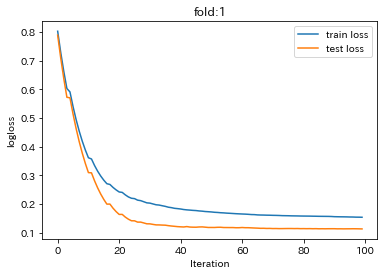

[I 2021-12-15 12:11:31,686] A new study created in memory with name: no-name-1f92e7b0-8d6b-4671-8f71-d89c63a46ef9


Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:32,033] Trial 0 finished with value: 0.17464593003271933 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.17464593003271933.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140306	Test's rmse: 0.174646
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:32,477] Trial 1 finished with value: 0.1442742824485471 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.1442742824485471.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123915	Test's rmse: 0.144274
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:32,951] Trial 2 finished with value: 0.14150262343439804 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.14150262343439804.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:33,323] Trial 3 finished with value: 0.16167365823684848 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.14150262343439804.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130492	Test's rmse: 0.161674
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:33,754] Trial 4 finished with value: 0.14231731003631473 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.14150262343439804.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124599	Test's rmse: 0.142317
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:34,245] Trial 5 finished with value: 0.139473228921955 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 0.139473228921955.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141856	Test's rmse: 0.139473
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:34,725] Trial 6 finished with value: 0.13925631595127572 and parameters: {'feature_fraction': 0.8}. Best is trial 6 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:36,228] Trial 7 finished with value: 0.14780492833402656 and parameters: {'num_leaves': 186}. Best is trial 7 with value: 0.14780492833402656.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135359	Test's rmse: 0.147805
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:37,251] Trial 8 finished with value: 0.14657997923934787 and parameters: {'num_leaves': 110}. Best is trial 8 with value: 0.14657997923934787.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136088	Test's rmse: 0.14658
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:39,092] Trial 9 finished with value: 0.14968239110580298 and parameters: {'num_leaves': 242}. Best is trial 8 with value: 0.14657997923934787.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133925	Test's rmse: 0.149682
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:39,849] Trial 10 finished with value: 0.1422536986480783 and parameters: {'num_leaves': 70}. Best is trial 10 with value: 0.1422536986480783.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137002	Test's rmse: 0.142254
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:41,371] Trial 11 finished with value: 0.14852010273450897 and parameters: {'num_leaves': 195}. Best is trial 10 with value: 0.1422536986480783.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134019	Test's rmse: 0.14852
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:43,171] Trial 12 finished with value: 0.1491971436334064 and parameters: {'num_leaves': 244}. Best is trial 10 with value: 0.1422536986480783.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133802	Test's rmse: 0.149197
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:43,814] Trial 13 finished with value: 0.14285021683179636 and parameters: {'num_leaves': 54}. Best is trial 10 with value: 0.1422536986480783.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135142	Test's rmse: 0.14285
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:45,362] Trial 14 finished with value: 0.14680510619788006 and parameters: {'num_leaves': 201}. Best is trial 10 with value: 0.1422536986480783.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137957	Test's rmse: 0.146805
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:47,036] Trial 15 finished with value: 0.14717032834568347 and parameters: {'num_leaves': 221}. Best is trial 10 with value: 0.1422536986480783.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135102	Test's rmse: 0.14717
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:48,456] Trial 16 finished with value: 0.14541731996717636 and parameters: {'num_leaves': 178}. Best is trial 10 with value: 0.1422536986480783.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131934	Test's rmse: 0.145417
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:48,826] Trial 17 finished with value: 0.14495699414204335 and parameters: {'num_leaves': 20}. Best is trial 10 with value: 0.1422536986480783.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129026	Test's rmse: 0.144957
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:49,456] Trial 18 finished with value: 0.14308654404430388 and parameters: {'num_leaves': 55}. Best is trial 10 with value: 0.1422536986480783.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138809	Test's rmse: 0.143087
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:50,349] Trial 19 finished with value: 0.1445235394216586 and parameters: {'num_leaves': 86}. Best is trial 10 with value: 0.1422536986480783.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13121	Test's rmse: 0.144524
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:50,608] Trial 20 finished with value: 0.1396407421543983 and parameters: {'num_leaves': 11}. Best is trial 20 with value: 0.1396407421543983.
[I 2021-12-15 12:11:50,773] Trial 21 finished with value: 0.16269649760226693 and parameters: {'num_leaves': 3}. Best is trial 20 with value: 0.1396407421543983.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128445	Test's rmse: 0.139641
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.199713	Test's rmse: 0.162696
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:52,061] Trial 22 finished with value: 0.1458970203949829 and parameters: {'num_leaves': 145}. Best is trial 20 with value: 0.1396407421543983.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138629	Test's rmse: 0.145897
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:52,610] Trial 23 finished with value: 0.14215774913536736 and parameters: {'num_leaves': 43}. Best is trial 20 with value: 0.1396407421543983.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136675	Test's rmse: 0.142158
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:53,113] Trial 24 finished with value: 0.1440702808301605 and parameters: {'num_leaves': 36}. Best is trial 20 with value: 0.1396407421543983.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139068	Test's rmse: 0.14407
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:54,072] Trial 25 finished with value: 0.14680935021193503 and parameters: {'num_leaves': 101}. Best is trial 20 with value: 0.1396407421543983.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13629	Test's rmse: 0.146809
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:55,292] Trial 26 finished with value: 0.14672429618571645 and parameters: {'num_leaves': 141}. Best is trial 20 with value: 0.1396407421543983.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13725	Test's rmse: 0.146724
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:55,764] Trial 27 finished with value: 0.15467969906126044 and parameters: {'bagging_fraction': 0.5667743882637518, 'bagging_freq': 1}. Best is trial 27 with value: 0.15467969906126044.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.171565	Test's rmse: 0.15468
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:56,311] Trial 28 finished with value: 0.15684080448594762 and parameters: {'bagging_fraction': 0.8179602759179444, 'bagging_freq': 4}. Best is trial 27 with value: 0.15467969906126044.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151782	Test's rmse: 0.156841
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:56,819] Trial 29 finished with value: 0.15088884895107754 and parameters: {'bagging_fraction': 0.6287446576990549, 'bagging_freq': 2}. Best is trial 29 with value: 0.15088884895107754.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164917	Test's rmse: 0.150889
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:57,361] Trial 30 finished with value: 0.1447244380671192 and parameters: {'bagging_fraction': 0.9545751907900759, 'bagging_freq': 2}. Best is trial 30 with value: 0.1447244380671192.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140022	Test's rmse: 0.144724
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:57,846] Trial 31 finished with value: 0.15761674426648836 and parameters: {'bagging_fraction': 0.4600063091181047, 'bagging_freq': 5}. Best is trial 30 with value: 0.1447244380671192.


Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.174034	Test's rmse: 0.157617
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:58,365] Trial 32 finished with value: 0.1549094515128719 and parameters: {'bagging_fraction': 0.4039455542329579, 'bagging_freq': 1}. Best is trial 30 with value: 0.1447244380671192.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.182467	Test's rmse: 0.154909
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:58,851] Trial 33 finished with value: 0.15940061465394212 and parameters: {'bagging_fraction': 0.4169986501415084, 'bagging_freq': 5}. Best is trial 30 with value: 0.1447244380671192.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.180795	Test's rmse: 0.159401
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:59,293] Trial 34 finished with value: 0.15698341853638362 and parameters: {'bagging_fraction': 0.6065039460653979, 'bagging_freq': 6}. Best is trial 30 with value: 0.1447244380671192.


Early stopping, best iteration is:
[35]	Train's rmse: 0.209731	Test's rmse: 0.156983
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:11:59,789] Trial 35 finished with value: 0.1561909885114882 and parameters: {'bagging_fraction': 0.6177416005470574, 'bagging_freq': 6}. Best is trial 30 with value: 0.1447244380671192.


Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.173547	Test's rmse: 0.156191
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:00,328] Trial 36 finished with value: 0.14153357560045354 and parameters: {'bagging_fraction': 0.9863300538962838, 'bagging_freq': 5}. Best is trial 36 with value: 0.14153357560045354.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.125046	Test's rmse: 0.141534
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:00,815] Trial 37 finished with value: 0.14161883447338924 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.14161883447338924.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142468	Test's rmse: 0.141619
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:01,281] Trial 38 finished with value: 0.14149331685906763 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 38 with value: 0.14149331685906763.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122336	Test's rmse: 0.141493
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:01,735] Trial 39 finished with value: 0.14149331685906763 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 0.14149331685906763.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122336	Test's rmse: 0.141493
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:02,239] Trial 40 finished with value: 0.14161883447338924 and parameters: {'feature_fraction': 0.88}. Best is trial 38 with value: 0.14149331685906763.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142468	Test's rmse: 0.141619
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:02,697] Trial 41 finished with value: 0.13925631595127572 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 41 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:03,122] Trial 42 finished with value: 0.14231731003631473 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 41 with value: 0.13925631595127572.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124599	Test's rmse: 0.142317
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:03,604] Trial 43 finished with value: 0.14385640575082945 and parameters: {'lambda_l1': 0.012636997451257995, 'lambda_l2': 4.684863811060764e-05}. Best is trial 43 with value: 0.14385640575082945.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137482	Test's rmse: 0.143856
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:04,062] Trial 44 finished with value: 0.14092825983746116 and parameters: {'lambda_l1': 0.04806854382751051, 'lambda_l2': 0.006899112754786772}. Best is trial 44 with value: 0.14092825983746116.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1281	Test's rmse: 0.140928
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:04,525] Trial 45 finished with value: 0.13925603962658015 and parameters: {'lambda_l1': 5.666194177300214e-07, 'lambda_l2': 0.0009776958414803398}. Best is trial 45 with value: 0.13925603962658015.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:04,989] Trial 46 finished with value: 0.1377344935507048 and parameters: {'lambda_l1': 0.0023970008339302584, 'lambda_l2': 2.136494273255737e-07}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128313	Test's rmse: 0.137734
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:05,447] Trial 47 finished with value: 0.14532974791317402 and parameters: {'lambda_l1': 0.00046614468661070963, 'lambda_l2': 1.9175735830974368}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130599	Test's rmse: 0.14533
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:05,912] Trial 48 finished with value: 0.14053270704405108 and parameters: {'lambda_l1': 0.004550983649242207, 'lambda_l2': 6.746393247702015e-06}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127016	Test's rmse: 0.140533
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:06,383] Trial 49 finished with value: 0.14055942030806604 and parameters: {'lambda_l1': 0.0011144392333438944, 'lambda_l2': 1.2568311416799472e-06}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13034	Test's rmse: 0.140559
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:06,834] Trial 50 finished with value: 0.13925598306677334 and parameters: {'lambda_l1': 1.1019711355371004e-06, 'lambda_l2': 0.0008287070134880197}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128874	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:07,297] Trial 51 finished with value: 0.13925631600902924 and parameters: {'lambda_l1': 2.0629932552746426e-08, 'lambda_l2': 2.8823943301195306e-08}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:07,743] Trial 52 finished with value: 0.1392563183088226 and parameters: {'lambda_l1': 1.347825253229204e-06, 'lambda_l2': 3.3500815356689025e-07}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:08,093] Trial 53 finished with value: 0.15952034432855694 and parameters: {'lambda_l1': 9.972124382874997, 'lambda_l2': 3.1493687412814424e-08}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161527	Test's rmse: 0.15952
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:08,577] Trial 54 finished with value: 0.13835079659777685 and parameters: {'lambda_l1': 7.0947067178201995e-06, 'lambda_l2': 0.01600822920263541}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130582	Test's rmse: 0.138351
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:09,045] Trial 55 finished with value: 0.14323595194194674 and parameters: {'lambda_l1': 5.5208772600652995e-06, 'lambda_l2': 0.0922197388799748}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138255	Test's rmse: 0.143236
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:09,517] Trial 56 finished with value: 0.14143924675726116 and parameters: {'lambda_l1': 5.549160108106284e-05, 'lambda_l2': 0.05255574759402925}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135603	Test's rmse: 0.141439
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:09,954] Trial 57 finished with value: 0.15688048820009334 and parameters: {'lambda_l1': 0.3439764046367649, 'lambda_l2': 8.851477231377919}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13924	Test's rmse: 0.15688
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:10,430] Trial 58 finished with value: 0.13925637122231738 and parameters: {'lambda_l1': 2.4769316226869278e-05, 'lambda_l2': 4.9329281748392976e-05}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:10,889] Trial 59 finished with value: 0.14162377743557156 and parameters: {'lambda_l1': 3.5682063237518856e-08, 'lambda_l2': 0.1800256435526959}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136548	Test's rmse: 0.141624
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:11,363] Trial 60 finished with value: 0.14018170873363406 and parameters: {'lambda_l1': 9.383466005274431e-05, 'lambda_l2': 0.008028954889313166}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131795	Test's rmse: 0.140182
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:11,811] Trial 61 finished with value: 0.14514776496324808 and parameters: {'lambda_l1': 0.3200068956541669, 'lambda_l2': 0.0001067297353987108}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135698	Test's rmse: 0.145148
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:12,267] Trial 62 finished with value: 0.13925631850057035 and parameters: {'lambda_l1': 1.5275656785791193e-07, 'lambda_l2': 5.746215953962737e-06}. Best is trial 46 with value: 0.1377344935507048.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128875	Test's rmse: 0.139256
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:12,755] Trial 63 finished with value: 0.15157344428363798 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.15157344428363798.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145907	Test's rmse: 0.151573
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:13,217] Trial 64 finished with value: 0.1964251013957603 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.15157344428363798.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.284261	Test's rmse: 0.196425
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:13,632] Trial 65 finished with value: 0.14512681428805535 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.14512681428805535.


Early stopping, best iteration is:
[39]	Train's rmse: 0.0764883	Test's rmse: 0.145127
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:14,079] Trial 66 finished with value: 0.15307750370378945 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.14512681428805535.


Early stopping, best iteration is:
[48]	Train's rmse: 0.111711	Test's rmse: 0.153078
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:14,565] Trial 67 finished with value: 0.18002835939030593 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.14512681428805535.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.227985	Test's rmse: 0.180028


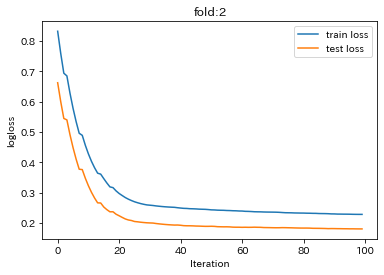

[I 2021-12-15 12:12:14,783] A new study created in memory with name: no-name-6cb55234-d8cd-4494-b512-e4cd0715ba9d


Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:15,195] Trial 0 finished with value: 0.06638633431207216 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.06638633431207216.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132491	Test's rmse: 0.0663863
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:15,647] Trial 1 finished with value: 0.02177254108325357 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.02177254108325357.


Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:16,044] Trial 2 finished with value: 0.08328249485144172 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.02177254108325357.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13123	Test's rmse: 0.0832825
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:16,522] Trial 3 finished with value: 0.03958827496350937 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.02177254108325357.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.153403	Test's rmse: 0.0395883
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:16,971] Trial 4 finished with value: 0.047424802730389466 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.02177254108325357.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12607	Test's rmse: 0.0474248
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:17,367] Trial 5 finished with value: 0.10061889839855907 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.02177254108325357.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137443	Test's rmse: 0.100619
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:17,736] Trial 6 finished with value: 0.10615833108191376 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.02177254108325357.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142166	Test's rmse: 0.106158
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:18,186] Trial 7 finished with value: 0.02177254108325357 and parameters: {'num_leaves': 31}. Best is trial 7 with value: 0.02177254108325357.


Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:19,784] Trial 8 finished with value: 0.022147412284828968 and parameters: {'num_leaves': 224}. Best is trial 7 with value: 0.02177254108325357.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165304	Test's rmse: 0.0221474
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:20,601] Trial 9 finished with value: 0.02191778641838677 and parameters: {'num_leaves': 80}. Best is trial 7 with value: 0.02177254108325357.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165386	Test's rmse: 0.0219178
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:21,652] Trial 10 finished with value: 0.02198533105958601 and parameters: {'num_leaves': 117}. Best is trial 7 with value: 0.02177254108325357.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165362	Test's rmse: 0.0219853
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:23,307] Trial 11 finished with value: 0.022160842980017633 and parameters: {'num_leaves': 234}. Best is trial 7 with value: 0.02177254108325357.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221608
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:23,722] Trial 12 finished with value: 0.021935765796860674 and parameters: {'num_leaves': 27}. Best is trial 7 with value: 0.02177254108325357.


Early stopping, best iteration is:
[43]	Train's rmse: 0.165192	Test's rmse: 0.0219358
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:24,660] Trial 13 finished with value: 0.021909723758205536 and parameters: {'num_leaves': 105}. Best is trial 7 with value: 0.02177254108325357.


Early stopping, best iteration is:
[43]	Train's rmse: 0.166251	Test's rmse: 0.0219097
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:25,610] Trial 14 finished with value: 0.02188603484912839 and parameters: {'num_leaves': 97}. Best is trial 7 with value: 0.02177254108325357.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164193	Test's rmse: 0.021886
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:26,260] Trial 15 finished with value: 0.020671486971142013 and parameters: {'num_leaves': 56}. Best is trial 15 with value: 0.020671486971142013.


Early stopping, best iteration is:
[44]	Train's rmse: 0.16676	Test's rmse: 0.0206715
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:27,611] Trial 16 finished with value: 0.022155053155727356 and parameters: {'num_leaves': 171}. Best is trial 15 with value: 0.020671486971142013.


Early stopping, best iteration is:
[43]	Train's rmse: 0.166136	Test's rmse: 0.0221551
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:28,945] Trial 17 finished with value: 0.022159056438877424 and parameters: {'num_leaves': 166}. Best is trial 15 with value: 0.020671486971142013.


Early stopping, best iteration is:
[43]	Train's rmse: 0.166136	Test's rmse: 0.0221591
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:29,139] Trial 18 finished with value: 0.040358139770047013 and parameters: {'num_leaves': 3}. Best is trial 15 with value: 0.020671486971142013.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.192896	Test's rmse: 0.0403581
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:29,666] Trial 19 finished with value: 0.021486528589939574 and parameters: {'num_leaves': 38}. Best is trial 15 with value: 0.020671486971142013.


Early stopping, best iteration is:
[45]	Train's rmse: 0.164201	Test's rmse: 0.0214865
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:30,310] Trial 20 finished with value: 0.022287558440883364 and parameters: {'num_leaves': 55}. Best is trial 15 with value: 0.020671486971142013.


Early stopping, best iteration is:
[42]	Train's rmse: 0.169267	Test's rmse: 0.0222876
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:31,007] Trial 21 finished with value: 0.02139796789692629 and parameters: {'num_leaves': 61}. Best is trial 15 with value: 0.020671486971142013.


Early stopping, best iteration is:
[42]	Train's rmse: 0.166631	Test's rmse: 0.021398
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:32,595] Trial 22 finished with value: 0.02251388723864122 and parameters: {'num_leaves': 71}. Best is trial 15 with value: 0.020671486971142013.


Early stopping, best iteration is:
[49]	Train's rmse: 0.161374	Test's rmse: 0.0225139
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:33,868] Trial 23 finished with value: 0.022031566156415227 and parameters: {'num_leaves': 147}. Best is trial 15 with value: 0.020671486971142013.


Early stopping, best iteration is:
[47]	Train's rmse: 0.16419	Test's rmse: 0.0220316
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:34,200] Trial 24 finished with value: 0.027644994983737684 and parameters: {'num_leaves': 13}. Best is trial 15 with value: 0.020671486971142013.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149615	Test's rmse: 0.027645
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:34,915] Trial 25 finished with value: 0.02250583568859805 and parameters: {'num_leaves': 60}. Best is trial 15 with value: 0.020671486971142013.


Early stopping, best iteration is:
[49]	Train's rmse: 0.161886	Test's rmse: 0.0225058
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:36,105] Trial 26 finished with value: 0.0222207330563623 and parameters: {'num_leaves': 134}. Best is trial 15 with value: 0.020671486971142013.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165915	Test's rmse: 0.0222207
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:36,865] Trial 27 finished with value: 0.027653757642670976 and parameters: {'bagging_fraction': 0.6473794266392014, 'bagging_freq': 5}. Best is trial 27 with value: 0.027653757642670976.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178241	Test's rmse: 0.0276538
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:37,599] Trial 28 finished with value: 0.0255462621178319 and parameters: {'bagging_fraction': 0.8946914962699879, 'bagging_freq': 1}. Best is trial 28 with value: 0.0255462621178319.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162261	Test's rmse: 0.0255463
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:38,394] Trial 29 finished with value: 0.032661949103599465 and parameters: {'bagging_fraction': 0.6708880664808674, 'bagging_freq': 7}. Best is trial 28 with value: 0.0255462621178319.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176246	Test's rmse: 0.0326619
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:39,204] Trial 30 finished with value: 0.030027933716811783 and parameters: {'bagging_fraction': 0.5747208832860782, 'bagging_freq': 4}. Best is trial 28 with value: 0.0255462621178319.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.179726	Test's rmse: 0.0300279
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:39,924] Trial 31 finished with value: 0.021807734908521365 and parameters: {'bagging_fraction': 0.9911037448047173, 'bagging_freq': 4}. Best is trial 31 with value: 0.021807734908521365.


Early stopping, best iteration is:
[44]	Train's rmse: 0.171859	Test's rmse: 0.0218077
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:40,704] Trial 32 finished with value: 0.02268659093400668 and parameters: {'bagging_fraction': 0.8107856597561536, 'bagging_freq': 6}. Best is trial 31 with value: 0.021807734908521365.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167159	Test's rmse: 0.0226866
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:41,492] Trial 33 finished with value: 0.029335395314592737 and parameters: {'bagging_fraction': 0.8178025575769223, 'bagging_freq': 4}. Best is trial 31 with value: 0.021807734908521365.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.172771	Test's rmse: 0.0293354
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:42,253] Trial 34 finished with value: 0.031452109441521665 and parameters: {'bagging_fraction': 0.4091902658520087, 'bagging_freq': 2}. Best is trial 31 with value: 0.021807734908521365.


Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.185854	Test's rmse: 0.0314521
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:42,963] Trial 35 finished with value: 0.0266124828255845 and parameters: {'bagging_fraction': 0.9016400267865601, 'bagging_freq': 1}. Best is trial 31 with value: 0.021807734908521365.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.162535	Test's rmse: 0.0266125
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:43,753] Trial 36 finished with value: 0.0281696414612533 and parameters: {'bagging_fraction': 0.9099680327444414, 'bagging_freq': 4}. Best is trial 31 with value: 0.021807734908521365.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.165885	Test's rmse: 0.0281696
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:44,480] Trial 37 finished with value: 0.04091390299538579 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.04091390299538579.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146033	Test's rmse: 0.0409139
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:45,159] Trial 38 finished with value: 0.040304034733015845 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 38 with value: 0.040304034733015845.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147243	Test's rmse: 0.040304
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:45,852] Trial 39 finished with value: 0.040304034733015845 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 0.040304034733015845.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147243	Test's rmse: 0.040304
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:46,346] Trial 40 finished with value: 0.02150742060153859 and parameters: {'lambda_l1': 0.049467681165535335, 'lambda_l2': 0.003389978574529725}. Best is trial 40 with value: 0.02150742060153859.


Early stopping, best iteration is:
[42]	Train's rmse: 0.166549	Test's rmse: 0.0215074
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:46,919] Trial 41 finished with value: 0.020375615916717597 and parameters: {'lambda_l1': 9.344020631220075e-08, 'lambda_l2': 2.1222207570903384}. Best is trial 41 with value: 0.020375615916717597.


Early stopping, best iteration is:
[47]	Train's rmse: 0.169227	Test's rmse: 0.0203756
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:47,566] Trial 42 finished with value: 0.020672222342382817 and parameters: {'lambda_l1': 1.720397849293805e-05, 'lambda_l2': 4.4839330421272685e-08}. Best is trial 41 with value: 0.020375615916717597.


Early stopping, best iteration is:
[44]	Train's rmse: 0.166759	Test's rmse: 0.0206722
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:48,081] Trial 43 finished with value: 0.020444153460036286 and parameters: {'lambda_l1': 0.026901154085438105, 'lambda_l2': 0.15426137238044466}. Best is trial 41 with value: 0.020375615916717597.


Early stopping, best iteration is:
[43]	Train's rmse: 0.165844	Test's rmse: 0.0204442
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:48,730] Trial 44 finished with value: 0.02067148546749693 and parameters: {'lambda_l1': 1.8391641401351066e-07, 'lambda_l2': 1.9312013443603727e-05}. Best is trial 41 with value: 0.020375615916717597.


Early stopping, best iteration is:
[44]	Train's rmse: 0.16676	Test's rmse: 0.0206715
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:49,069] Trial 45 finished with value: 0.023981798668506003 and parameters: {'lambda_l1': 2.664786566580779, 'lambda_l2': 0.14108345157460278}. Best is trial 41 with value: 0.020375615916717597.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143824	Test's rmse: 0.0239818
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:49,655] Trial 46 finished with value: 0.02571061562132601 and parameters: {'lambda_l1': 2.851522387162517e-06, 'lambda_l2': 5.386095260378313}. Best is trial 41 with value: 0.020375615916717597.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152746	Test's rmse: 0.0257106
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:50,351] Trial 47 finished with value: 0.027809970561189373 and parameters: {'lambda_l1': 1.655515410002484e-08, 'lambda_l2': 0.00029709651486373867}. Best is trial 41 with value: 0.020375615916717597.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152835	Test's rmse: 0.02781
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:50,992] Trial 48 finished with value: 0.02153010142859219 and parameters: {'lambda_l1': 2.655105355783862e-07, 'lambda_l2': 0.009579529423978893}. Best is trial 41 with value: 0.020375615916717597.


Early stopping, best iteration is:
[44]	Train's rmse: 0.167449	Test's rmse: 0.0215301
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:51,647] Trial 49 finished with value: 0.022016449492807497 and parameters: {'lambda_l1': 0.0004971176423079169, 'lambda_l2': 3.3389243183040255e-05}. Best is trial 41 with value: 0.020375615916717597.


Early stopping, best iteration is:
[45]	Train's rmse: 0.165388	Test's rmse: 0.0220164
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:52,297] Trial 50 finished with value: 0.02188670363428225 and parameters: {'lambda_l1': 0.0001857222178465396, 'lambda_l2': 3.1471928591520875e-08}. Best is trial 41 with value: 0.020375615916717597.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164595	Test's rmse: 0.0218867
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:52,850] Trial 51 finished with value: 0.025529994820936402 and parameters: {'lambda_l1': 0.017330420657987466, 'lambda_l2': 9.258565530603638}. Best is trial 41 with value: 0.020375615916717597.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158991	Test's rmse: 0.02553
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:53,437] Trial 52 finished with value: 0.019602640469804502 and parameters: {'lambda_l1': 0.024995130395760845, 'lambda_l2': 0.08707264604535862}. Best is trial 52 with value: 0.019602640469804502.


Early stopping, best iteration is:
[43]	Train's rmse: 0.167855	Test's rmse: 0.0196026
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:53,750] Trial 53 finished with value: 0.03346319791536371 and parameters: {'lambda_l1': 6.392758152994818, 'lambda_l2': 0.34239308217168946}. Best is trial 52 with value: 0.019602640469804502.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145078	Test's rmse: 0.0334632
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:54,353] Trial 54 finished with value: 0.02148910606146042 and parameters: {'lambda_l1': 0.0016137357665380542, 'lambda_l2': 0.6230446914344945}. Best is trial 52 with value: 0.019602640469804502.


Early stopping, best iteration is:
[46]	Train's rmse: 0.164871	Test's rmse: 0.0214891
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:54,855] Trial 55 finished with value: 0.02140994890240009 and parameters: {'lambda_l1': 0.1570142337267727, 'lambda_l2': 0.010432701751338572}. Best is trial 52 with value: 0.019602640469804502.


Early stopping, best iteration is:
[44]	Train's rmse: 0.164606	Test's rmse: 0.0214099
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:55,528] Trial 56 finished with value: 0.02222958049386875 and parameters: {'lambda_l1': 2.757638696125476e-05, 'lambda_l2': 0.029343190779068974}. Best is trial 52 with value: 0.019602640469804502.


Early stopping, best iteration is:
[47]	Train's rmse: 0.164593	Test's rmse: 0.0222296
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:55,994] Trial 57 finished with value: 0.019965456689238974 and parameters: {'lambda_l1': 0.34798255725431393, 'lambda_l2': 0.0007610053190064176}. Best is trial 52 with value: 0.019602640469804502.


Early stopping, best iteration is:
[46]	Train's rmse: 0.164305	Test's rmse: 0.0199655
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:56,471] Trial 58 finished with value: 0.021882057906883173 and parameters: {'lambda_l1': 0.2236920215825347, 'lambda_l2': 1.3027118857489957e-06}. Best is trial 52 with value: 0.019602640469804502.


Early stopping, best iteration is:
[47]	Train's rmse: 0.163479	Test's rmse: 0.0218821
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:57,087] Trial 59 finished with value: 0.021344631598623345 and parameters: {'lambda_l1': 0.0029257242583206203, 'lambda_l2': 0.0006542921986793872}. Best is trial 52 with value: 0.019602640469804502.


Early stopping, best iteration is:
[44]	Train's rmse: 0.166241	Test's rmse: 0.0213446
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:57,663] Trial 60 finished with value: 0.025336409078580584 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 0.025336409078580584.


Early stopping, best iteration is:
[44]	Train's rmse: 0.174252	Test's rmse: 0.0253364
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:58,137] Trial 61 finished with value: 0.02246784366105816 and parameters: {'min_child_samples': 5}. Best is trial 61 with value: 0.02246784366105816.


Early stopping, best iteration is:
[40]	Train's rmse: 0.0523241	Test's rmse: 0.0224678
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:58,667] Trial 62 finished with value: 0.08642673249931476 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.02246784366105816.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.293846	Test's rmse: 0.0864267
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:59,175] Trial 63 finished with value: 0.028169139132948894 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 0.02246784366105816.


Early stopping, best iteration is:
[38]	Train's rmse: 0.116364	Test's rmse: 0.0281691
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:12:59,671] Trial 64 finished with value: 0.056895207399405984 and parameters: {'min_child_samples': 50}. Best is trial 61 with value: 0.02246784366105816.


Early stopping, best iteration is:
[38]	Train's rmse: 0.255405	Test's rmse: 0.0568952


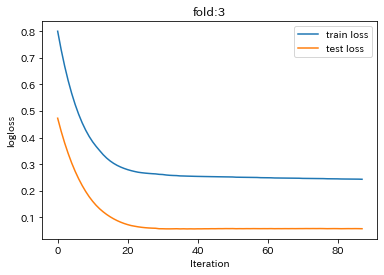

[I 2021-12-15 12:12:59,895] A new study created in memory with name: no-name-e2f942d1-3b91-451b-b29b-81a3cff5455f


Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:00,251] Trial 0 finished with value: 0.41194801855330004 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.41194801855330004.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.127532	Test's rmse: 0.411948
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:00,658] Trial 1 finished with value: 0.41325813010412743 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.41194801855330004.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121666	Test's rmse: 0.413258
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:01,088] Trial 2 finished with value: 0.407667454479844 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.407667454479844.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119068	Test's rmse: 0.407667
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:01,542] Trial 3 finished with value: 0.38854610452293914 and parameters: {'feature_fraction': 0.8}. Best is trial 3 with value: 0.38854610452293914.


Early stopping, best iteration is:
[48]	Train's rmse: 0.15319	Test's rmse: 0.388546
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:01,994] Trial 4 finished with value: 0.39792690629008476 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.38854610452293914.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119956	Test's rmse: 0.397927
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:02,435] Trial 5 finished with value: 0.38020058278906177 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 0.38020058278906177.


Early stopping, best iteration is:
[36]	Train's rmse: 0.157903	Test's rmse: 0.380201
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:02,867] Trial 6 finished with value: 0.37303280377763515 and parameters: {'feature_fraction': 1.0}. Best is trial 6 with value: 0.37303280377763515.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:03,283] Trial 7 finished with value: 0.37380155735017107 and parameters: {'num_leaves': 32}. Best is trial 7 with value: 0.37380155735017107.


Early stopping, best iteration is:
[31]	Train's rmse: 0.159774	Test's rmse: 0.373802
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:04,539] Trial 8 finished with value: 0.37606396960938115 and parameters: {'num_leaves': 193}. Best is trial 7 with value: 0.37380155735017107.


Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376064
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:05,438] Trial 9 finished with value: 0.3760653268990991 and parameters: {'num_leaves': 110}. Best is trial 7 with value: 0.37380155735017107.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159186	Test's rmse: 0.376065
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:06,846] Trial 10 finished with value: 0.37576800530090637 and parameters: {'num_leaves': 203}. Best is trial 7 with value: 0.37380155735017107.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:07,712] Trial 11 finished with value: 0.37576698513609913 and parameters: {'num_leaves': 100}. Best is trial 7 with value: 0.37380155735017107.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153043	Test's rmse: 0.375767
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:08,265] Trial 12 finished with value: 0.3760765551719972 and parameters: {'num_leaves': 51}. Best is trial 7 with value: 0.37380155735017107.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159209	Test's rmse: 0.376077
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:08,938] Trial 13 finished with value: 0.3761163778551823 and parameters: {'num_leaves': 70}. Best is trial 7 with value: 0.37380155735017107.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159225	Test's rmse: 0.376116
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:09,171] Trial 14 finished with value: 0.36105902060784245 and parameters: {'num_leaves': 8}. Best is trial 14 with value: 0.36105902060784245.


Early stopping, best iteration is:
[38]	Train's rmse: 0.15377	Test's rmse: 0.361059
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:10,307] Trial 15 finished with value: 0.37576565835810277 and parameters: {'num_leaves': 147}. Best is trial 14 with value: 0.36105902060784245.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153042	Test's rmse: 0.375766
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:10,989] Trial 16 finished with value: 0.37609897249943963 and parameters: {'num_leaves': 72}. Best is trial 14 with value: 0.36105902060784245.


Early stopping, best iteration is:
[32]	Train's rmse: 0.159198	Test's rmse: 0.376099
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:11,258] Trial 17 finished with value: 0.37452473564088873 and parameters: {'num_leaves': 13}. Best is trial 14 with value: 0.36105902060784245.
[I 2021-12-15 12:13:11,444] Trial 18 finished with value: 0.34821864623888243 and parameters: {'num_leaves': 5}. Best is trial 18 with value: 0.34821864623888243.


Early stopping, best iteration is:
[34]	Train's rmse: 0.155954	Test's rmse: 0.374525
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[36]	Train's rmse: 0.166868	Test's rmse: 0.348219


[I 2021-12-15 12:13:11,676] Trial 19 finished with value: 0.36105902060784245 and parameters: {'num_leaves': 8}. Best is trial 18 with value: 0.34821864623888243.


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[38]	Train's rmse: 0.15377	Test's rmse: 0.361059
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:12,905] Trial 20 finished with value: 0.3757671221534982 and parameters: {'num_leaves': 157}. Best is trial 18 with value: 0.34821864623888243.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153027	Test's rmse: 0.375767
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:14,532] Trial 21 finished with value: 0.37576803714576895 and parameters: {'num_leaves': 250}. Best is trial 18 with value: 0.34821864623888243.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.375768
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:14,726] Trial 22 finished with value: 0.3645463404681194 and parameters: {'num_leaves': 4}. Best is trial 18 with value: 0.34821864623888243.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.13478	Test's rmse: 0.364546
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:15,244] Trial 23 finished with value: 0.37291798515496444 and parameters: {'num_leaves': 38}. Best is trial 18 with value: 0.34821864623888243.


Early stopping, best iteration is:
[38]	Train's rmse: 0.152714	Test's rmse: 0.372918
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:16,001] Trial 24 finished with value: 0.3757705561577217 and parameters: {'num_leaves': 77}. Best is trial 18 with value: 0.34821864623888243.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153035	Test's rmse: 0.375771
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:16,523] Trial 25 finished with value: 0.3730384452124601 and parameters: {'num_leaves': 43}. Best is trial 18 with value: 0.34821864623888243.


Early stopping, best iteration is:
[38]	Train's rmse: 0.152838	Test's rmse: 0.373038
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:17,439] Trial 26 finished with value: 0.37576667990931545 and parameters: {'num_leaves': 105}. Best is trial 18 with value: 0.34821864623888243.


Early stopping, best iteration is:
[39]	Train's rmse: 0.153044	Test's rmse: 0.375767
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:17,671] Trial 27 finished with value: 0.352159096449736 and parameters: {'bagging_fraction': 0.5436224404770587, 'bagging_freq': 4}. Best is trial 27 with value: 0.352159096449736.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166577	Test's rmse: 0.352159
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:17,921] Trial 28 finished with value: 0.3534254672616933 and parameters: {'bagging_fraction': 0.7953726876161689, 'bagging_freq': 4}. Best is trial 27 with value: 0.352159096449736.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154294	Test's rmse: 0.353425
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:18,161] Trial 29 finished with value: 0.36755919408272564 and parameters: {'bagging_fraction': 0.6124756426433645, 'bagging_freq': 4}. Best is trial 27 with value: 0.352159096449736.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161899	Test's rmse: 0.367559
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:18,430] Trial 30 finished with value: 0.36264431198322716 and parameters: {'bagging_fraction': 0.9462945275479219, 'bagging_freq': 2}. Best is trial 27 with value: 0.352159096449736.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140963	Test's rmse: 0.362644
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:18,647] Trial 31 finished with value: 0.3352756114450934 and parameters: {'bagging_fraction': 0.52131303873783, 'bagging_freq': 6}. Best is trial 31 with value: 0.3352756114450934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177388	Test's rmse: 0.335276
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:18,876] Trial 32 finished with value: 0.3532823342794413 and parameters: {'bagging_fraction': 0.45900003974302805, 'bagging_freq': 7}. Best is trial 31 with value: 0.3352756114450934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171656	Test's rmse: 0.353282
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:19,127] Trial 33 finished with value: 0.35618524850582184 and parameters: {'bagging_fraction': 0.6937249167342212, 'bagging_freq': 2}. Best is trial 31 with value: 0.3352756114450934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158806	Test's rmse: 0.356185
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:19,372] Trial 34 finished with value: 0.3533577900956113 and parameters: {'bagging_fraction': 0.7985712265005773, 'bagging_freq': 4}. Best is trial 31 with value: 0.3352756114450934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.15501	Test's rmse: 0.353358
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:19,615] Trial 35 finished with value: 0.36557433258769007 and parameters: {'bagging_fraction': 0.9253298213047517, 'bagging_freq': 2}. Best is trial 31 with value: 0.3352756114450934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141573	Test's rmse: 0.365574
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:19,843] Trial 36 finished with value: 0.36193251365314777 and parameters: {'bagging_fraction': 0.6493039230860083, 'bagging_freq': 1}. Best is trial 31 with value: 0.3352756114450934.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160296	Test's rmse: 0.361933
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:20,080] Trial 37 finished with value: 0.3394861423141941 and parameters: {'feature_fraction': 0.92}. Best is trial 37 with value: 0.3394861423141941.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176652	Test's rmse: 0.339486
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:20,303] Trial 38 finished with value: 0.33617216056137234 and parameters: {'feature_fraction': 0.9520000000000001}. Best is trial 38 with value: 0.33617216056137234.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176132	Test's rmse: 0.336172
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:20,552] Trial 39 finished with value: 0.33617216056137234 and parameters: {'feature_fraction': 0.9840000000000001}. Best is trial 38 with value: 0.33617216056137234.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176132	Test's rmse: 0.336172
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:20,784] Trial 40 finished with value: 0.33781896232640846 and parameters: {'lambda_l1': 3.7617656371608994e-08, 'lambda_l2': 1.8089106614577735}. Best is trial 40 with value: 0.33781896232640846.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178899	Test's rmse: 0.337819
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:21,006] Trial 41 finished with value: 0.3411741651846149 and parameters: {'lambda_l1': 4.116457725613085, 'lambda_l2': 0.002964396302109868}. Best is trial 40 with value: 0.33781896232640846.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.175899	Test's rmse: 0.341174
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:21,250] Trial 42 finished with value: 0.33694237052701265 and parameters: {'lambda_l1': 1.9573424336028542e-07, 'lambda_l2': 0.7247463293263561}. Best is trial 42 with value: 0.33694237052701265.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17747	Test's rmse: 0.336942
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:21,487] Trial 43 finished with value: 0.33520214695421396 and parameters: {'lambda_l1': 0.00720160209911884, 'lambda_l2': 0.00033129524405899676}. Best is trial 43 with value: 0.33520214695421396.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177405	Test's rmse: 0.335202
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:21,707] Trial 44 finished with value: 0.3352720922606257 and parameters: {'lambda_l1': 0.003964219523566258, 'lambda_l2': 0.0007889616609780481}. Best is trial 43 with value: 0.33520214695421396.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177399	Test's rmse: 0.335272
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:21,952] Trial 45 finished with value: 0.335275611396023 and parameters: {'lambda_l1': 6.488883401275445e-07, 'lambda_l2': 1.5948011917825468e-08}. Best is trial 43 with value: 0.33520214695421396.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177388	Test's rmse: 0.335276
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:22,194] Trial 46 finished with value: 0.33520109669111636 and parameters: {'lambda_l1': 0.010352266630008442, 'lambda_l2': 1.1989130675074976e-07}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17741	Test's rmse: 0.335201
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:22,411] Trial 47 finished with value: 0.33527560548272883 and parameters: {'lambda_l1': 1.609700502731328e-05, 'lambda_l2': 2.8285159701108757e-08}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177388	Test's rmse: 0.335276
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:22,632] Trial 48 finished with value: 0.33653931057880077 and parameters: {'lambda_l1': 8.893810995337338, 'lambda_l2': 6.31096996512432e-05}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.180321	Test's rmse: 0.336539
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:22,863] Trial 49 finished with value: 0.33527351475152134 and parameters: {'lambda_l1': 9.687049698671383e-08, 'lambda_l2': 0.010585436852241097}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1774	Test's rmse: 0.335274
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:23,099] Trial 50 finished with value: 0.3353487100379758 and parameters: {'lambda_l1': 0.07502394855274618, 'lambda_l2': 1.2693956936432572e-06}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177474	Test's rmse: 0.335349
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:23,336] Trial 51 finished with value: 0.33527522298969337 and parameters: {'lambda_l1': 0.0010106190124557462, 'lambda_l2': 5.557729119496026e-06}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177389	Test's rmse: 0.335275
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:23,573] Trial 52 finished with value: 0.33655275044544164 and parameters: {'lambda_l1': 0.05137690387717805, 'lambda_l2': 1.6813685927202585e-06}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177638	Test's rmse: 0.336553
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:23,818] Trial 53 finished with value: 0.33527559247088906 and parameters: {'lambda_l1': 4.843398488997125e-05, 'lambda_l2': 4.991931803397146e-05}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177388	Test's rmse: 0.335276
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:24,037] Trial 54 finished with value: 0.33655072890756577 and parameters: {'lambda_l1': 0.05322944130468444, 'lambda_l2': 0.013573885999238677}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177653	Test's rmse: 0.336551
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:24,286] Trial 55 finished with value: 0.3352719526246519 and parameters: {'lambda_l1': 0.004348464833159607, 'lambda_l2': 2.1567175189910022e-07}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177399	Test's rmse: 0.335272
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:24,514] Trial 56 finished with value: 0.33683355990972774 and parameters: {'lambda_l1': 0.5486139102687276, 'lambda_l2': 0.00010095923034209782}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.178378	Test's rmse: 0.336834
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:24,741] Trial 57 finished with value: 0.3356731714646456 and parameters: {'lambda_l1': 0.00013997096377937185, 'lambda_l2': 0.07889000809175716}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177346	Test's rmse: 0.335673
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:24,960] Trial 58 finished with value: 0.3352714415883946 and parameters: {'lambda_l1': 0.005676730275917424, 'lambda_l2': 1.0918086491355229e-05}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177401	Test's rmse: 0.335271
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:25,207] Trial 59 finished with value: 0.3352756047224431 and parameters: {'lambda_l1': 1.76361160463728e-05, 'lambda_l2': 2.1741239873178104e-07}. Best is trial 46 with value: 0.33520109669111636.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177388	Test's rmse: 0.335276
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:25,430] Trial 60 finished with value: 0.42822518396392245 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.42822518396392245.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.219355	Test's rmse: 0.428225
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:25,645] Trial 61 finished with value: 0.35781754435962004 and parameters: {'min_child_samples': 10}. Best is trial 61 with value: 0.35781754435962004.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.132523	Test's rmse: 0.357818
Training until validation scores don't improve for 50 rounds.


[I 2021-12-15 12:13:25,881] Trial 62 finished with value: 0.5287785530777845 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.35781754435962004.


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.279089	Test's rmse: 0.528779
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.100434	Test's rmse: 0.359922


[I 2021-12-15 12:13:26,079] Trial 63 finished with value: 0.35992208478267335 and parameters: {'min_child_samples': 5}. Best is trial 61 with value: 0.35781754435962004.
[I 2021-12-15 12:13:26,311] Trial 64 finished with value: 0.3420929442158407 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.3420929442158407.


Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177344	Test's rmse: 0.342093


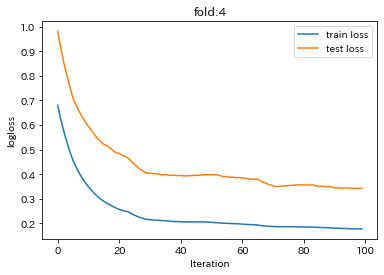

RMSE: [0.3168197986425456, 0.09186100991345529, 0.13773449637370594, 0.01960263959756659, 0.33520109652636815]
RMSE: 0.18024380821072833


In [ ]:
start = time.time()

# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 多クラス分類を指定
          'metric': 'rmse',  # 多クラス分類の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'deterministic':True,         # 再現性確保用のパラメータ
          'force_row_wise':True,        # 再現性確保用のパラメータ
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result = []

for i, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.LightGBMTuner(
                    params,                    # ハイパーパラメータをセット
                    train_set = lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    evals_result=lgb_results,
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    show_progress_bar = False,        # プログレスバーの非表示
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )
    
    # 訓練の実施
    model.run()

    best_params = model.best_params
    best_model = model.get_best_booster()

    pickle.dump(best_model, open(f"model_fold_{i}.pkl", 'wb')) # モデルの保存
    
    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{i}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = best_model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result.append(rmse)

print("RMSE:", cv_result)
print("RMSE:", np.mean(cv_result))

elasped_time = round((time.time() - start), 1)

## モデルの読込

In [ ]:
start_loaded = time.time()

cv_result_loaded = []

for i, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    loaded_model = pickle.load(open(f"model_fold_{i}.pkl", 'rb'))
    y_pred = loaded_model.predict(X_test_gkf)

    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_loaded.append(rmse)

print("RMSE:", cv_result_loaded)
print("RMSE:", np.mean(cv_result_loaded))
elasped_time_loaded = round((time.time() - start_loaded), 1)

RMSE: [0.3168197986425456, 0.09186100991345529, 0.13773449637370594, 0.01960263959756659, 0.33520109652636815]
RMSE: 0.18024380821072833


In [ ]:
print("RMSE:", np.mean(cv_result))
print(f"経過時間:{elasped_time}")

print("pickle読込 RMSE:", np.mean(cv_result_loaded))
print(f"pickle読込 経過時間:{elasped_time_loaded}")

RMSE: 0.18024380821072833
経過時間:203.7
pickle読込 RMSE: 0.18024380821072833
pickle読込 経過時間:0.3
